<a href="https://colab.research.google.com/github/vsolodkyi/NeuralNetworks_SkillBox/blob/main/module_14/%D0%A0%D0%B5%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%82%D0%BE%D1%80%D0%B0_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Реализация  и обучение классификатора текстов

Рассмотрим реализацию классификатора текстов на примере классификации отзывов на фильмы (положительный или отрицательный). Для этого будем использовать классический датасет IMDB.

### Используем TensorFlow 2.0

На момент подготовки этих материалов в Google Colab по умолчанию используется версия TensorFlow 1.X

Переключаемся на версию 2.0 (работает только в Colab)

In [1]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


### Загрузка библиотек
TensorFlow должен иметь как минимум версию 2.0

In [2]:
import numpy as np
import tensorflow as tf
print(tf.__version__)

import matplotlib.pyplot as plt
%matplotlib inline

2.8.2


### Загрузка датасета IMDB
Загружаем датасет IMDB (обучающую и тестовую выборки). Во время загрузки датасета можно указать, какое подмножество словаря мы хотим использовать, указав `num_words=VOCAB_SIZE`, тогда останутся только самые частые слова.

В датасете последовательности (предложения) уже представлены индексами слов.

In [3]:
VOCAB_SIZE = 10000 # Количество слов в словаре

(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.imdb.load_data(num_words=VOCAB_SIZE)

print("Training entries: {}".format(len(train_data)))
print('=====================================')
print("Test entries: {}".format(len(test_data)))
print('=====================================')
print("Length examples: {}".format([len(train_data[0]), len(train_data[1])]))
print('=====================================')
print("Entry example: {}".format(train_data[0]))

17473536/17464789 [==============================] - 0s 0us/step
Training entries: 25000
Test entries: 25000
Length examples: [218, 189]
Entry example: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 22

### Создание функций decode_review и encode_review
Создадим функции для конвертирования индексного представления отзыва в словесный (`decode_review`) и наоборот (`encode_review`).

Функции будут используют словари `word2idx` и `idx2word` (отображение слова в индекс и индекса в слово)

Кроме обычные слов в словаре будут содержаться специальные слова (токены): `<PAD>`, `<START>`, `<UNKNOWN>`


In [4]:
word_index = tf.keras.datasets.imdb.get_word_index()

word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNKNOWN>"] = 2

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# последовательность индексов в текст
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

# текст в последовательность индексов
def encode_review(text):
    words = text.lower().split()
    words = ['<START>'] + words
    idxs = [word_index.get(word, word_index['<UNKNOWN>']) for word in words]
    return idxs

print('Example of a decoded review: \n{}'.format(decode_review(train_data[0])))

1654784/1641221 [==============================] - 0s 0us/step
Example of a decoded review: 
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNKNOWN> is an amazing actor and now the same being director <UNKNOWN> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNKNOWN> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNKNOWN> to the two little boy's that played the <UNKNOWN> of norman and paul they were just brilliant children are often left out of the <UNKNOWN> list i think because the stars that play the

### Проверка работы функций decode_review и encode_review
Протестируем функции `decode_review` и `encode_review`

In [5]:
text = 'hello world'

print(encode_review(text))
print(decode_review(encode_review(text)))

[1, 4825, 182]
<START> hello world


### Приведение всех цепочек в датасете к одной длине с помощью паддинга
Одна цепочка это один отзыв. А отзывы могут быть различной длины. 

Так как нам будет необходимо собирать из отзывов батчи (группы цепочек), удобно все отзывы привести к одной длине с помощью падинга в конце (добавлением элементов `<PAD>`).

In [6]:
MAX_SEQ_LEN = 256 # Финальная длина последовательности

train_data = tf.keras.preprocessing.sequence.pad_sequences(
    train_data,
    value=word_index["<PAD>"],
    padding='post',
    maxlen=MAX_SEQ_LEN)

test_data = tf.keras.preprocessing.sequence.pad_sequences(
    test_data,
    value=word_index["<PAD>"],
    padding='post',
    maxlen=MAX_SEQ_LEN)

print("Length examples: {}".format([len(train_data[0]), len(train_data[1])]))
print('=====================================')
print("Entry example: {}".format(train_data[0]))

Length examples: [256, 256]
Entry example: [   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   1

### Создание модели
Создадим модель для бинарной классификации текстов.

Здесь для простоты демонстрации будем использовать НЕ рекуррентную нейросеть, а обычную сеть прямого распространения. А после этого вам нужно будет использовать знания о рекуррентных сетях и применить их для решения той же задачи.

Итак, давайте сначала воспользуемся сетью прямого распространения. Но такая нейросеть может обрабатывать лишь один входной объект (вектор), а у нас на входе последовательность векторов. Как можно перейти от последовательности к чему-то одному? 

Воспользуемся для этого слоем `GlobalAveragePooling1D`, который просто усреднит все вектора во входной последовательности и получит один выходной (промежуточный) вектор, который мы уже подадим на вход в полносвязную сеть. 

In [7]:
EMB_SIZE = 16 # Размер векторного представления (эмбеддинга)
    
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, 16),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


### Подготовка модели к обучению
Далее мы будем обучать модель так же, как обычный классификатор.

In [8]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

### Разбиение обучающего датасета на обучающий и валидационный

In [9]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

### Обучение модели

In [10]:
BATCH_SIZE = 512
NUM_EPOCHS = 20

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 4s 12ms/step - loss: 0.6918 - acc: 0.6010 - val_loss: 0.6898 - val_acc: 0.6252
Epoch 2/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6866 - acc: 0.6582 - val_loss: 0.6827 - val_acc: 0.6936
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.6756 - acc: 0.7203 - val_loss: 0.6686 - val_acc: 0.7369
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.6564 - acc: 0.7309 - val_loss: 0.6471 - val_acc: 0.7725
Epoch 5/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6281 - acc: 0.7865 - val_loss: 0.6161 - val_acc: 0.7736
Epoch 6/20
30/30 [==============================] - 0s 7ms/step - loss: 0.5909 - acc: 0.7961 - val_loss: 0.5796 - val_acc: 0.8024
Epoch 7/20
30/30 [==============================] - 0s 7ms/step - loss: 0.5481 - acc: 0.8270 - val_loss: 0.5388 - val_acc: 0.8151
Epoch 8/20
30/30 [==============================] - 0s 7ms/step - loss: 0.5032 - acc: 0.8

### Оценка качества на тестовом датасете

In [11]:
results = model.evaluate(test_data, test_labels)

print('Test loss: {:.4f}'.format(results[0]))
print('Test accuracy: {:.2f} %'.format(results[1]*100))

782/782 [==============================] - 2s 2ms/step - loss: 0.3128 - acc: 0.8734
Test loss: 0.3128
Test accuracy: 87.34 %


### Графики лосса и точности на обучающем и валидационном датасетах

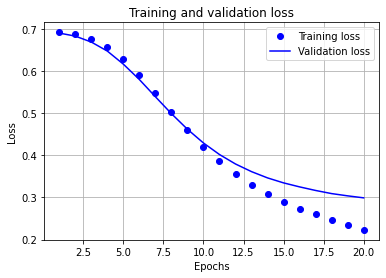

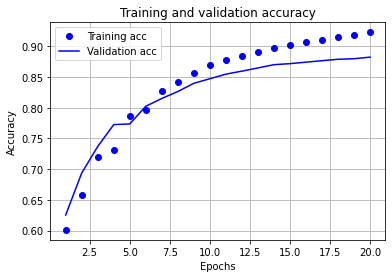

In [12]:
epochs = range(1, len(history.history['acc']) + 1)

plt.figure()
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(epochs, history.history['acc'], 'bo', label='Training acc')
plt.plot(epochs, history.history['val_acc'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

### Тестирование обученной модели на новой последовательности

Проверим работу модели на собственном отзыве.

Напишем текст (отзыв), закодируем его в индексы с помощью `encode_review` и подадим на вход в нейронную сеть, приклеив батч-измерение. Выход из сети -- вероятность того, что отзыв положительный.

In [13]:
text = 'It was a really good movie it was so fantastic'

encoded = encode_review(text)
prediction = model.predict(np.array(encoded)[None, :])[0,0]

print(prediction)
print('Positive' if prediction > 0.5 else 'Negative')

0.99913377
Positive


В нашем решении выше мы воспользовались тем, что просто усреднили информацию обо всех словах и никак не использовали тот факт, что эти слова идут в определённой последовательности. То есть применение простых сетей прямого распространения может сработать для не очень сложных задач, где важны лишь какие-то ключевые слова, типа "хороший фильм" или "плохой фильм". Однако, как мы знаем, рекуррентные нейросети могут отслеживать закономерности в последовательностях и обладают намного более мощным потенциалом. 

**[Задание 1]** Замените модель прямого распространения на рекуррентную модель и обучите на датасете IMDB. Попробуйте различное количество рекуррентных слоёв, LSTM или GRU, различные гиперпараметры, двунаправленные сети и другие знания из предыдущих модулей.  

In [14]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, 16),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(16, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(16, return_sequences=False, dropout=0.5, recurrent_dropout=0.5)),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid),
])



In [15]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 32)         4224      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 170,529
Trainable params: 170,529
Non-trainable params: 0
_________________________________________________________________


In [16]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [17]:
BATCH_SIZE = 512
NUM_EPOCHS = 20

history_lstm = model_lstm.fit(partial_x_train,
                    partial_y_train,
                    epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 142s 4s/step - loss: 0.6927 - acc: 0.5140 - val_loss: 0.6916 - val_acc: 0.5426
Epoch 2/20
30/30 [==============================] - 129s 4s/step - loss: 0.6686 - acc: 0.6123 - val_loss: 0.5810 - val_acc: 0.7178
Epoch 3/20
30/30 [==============================] - 126s 4s/step - loss: 0.4846 - acc: 0.7865 - val_loss: 0.4262 - val_acc: 0.8172
Epoch 4/20
30/30 [==============================] - 126s 4s/step - loss: 0.3785 - acc: 0.8473 - val_loss: 0.3892 - val_acc: 0.8329
Epoch 5/20
30/30 [==============================] - 126s 4s/step - loss: 0.3108 - acc: 0.8781 - val_loss: 0.3412 - val_acc: 0.8657
Epoch 6/20
30/30 [==============================] - 123s 4s/step - loss: 0.2663 - acc: 0.9018 - val_loss: 0.3354 - val_acc: 0.8724
Epoch 7/20
30/30 [==============================] - 124s 4s/step - loss: 0.2534 - acc: 0.9095 - val_loss: 0.3506 - val_acc: 0.8699
Epoch 8/20
30/30 [==============================] - 124s 4s/step - loss: 0.2323 - a

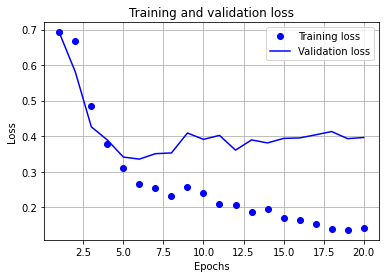

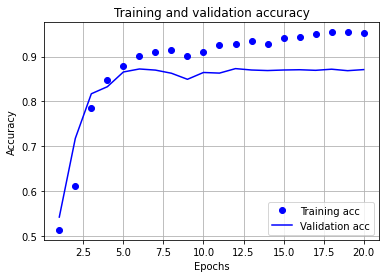

In [18]:
epochs = range(1, len(history_lstm.history['acc']) + 1)

plt.figure()
plt.plot(epochs, history_lstm.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history_lstm.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(epochs, history_lstm.history['acc'], 'bo', label='Training acc')
plt.plot(epochs, history_lstm.history['val_acc'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

In [19]:
text = 'It was a really good movie it was so fantastic'

encoded = encode_review(text)
prediction_new = model_lstm.predict(np.array(encoded)[None, :])[0,0]

print(prediction_new)
print('Positive' if prediction_new > 0.5 else 'Negative')

0.8773059
Positive
